In [1]:
import os
import warnings

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow as tf
import tensorflow_model_analysis as tfma

from tfx.components import (
    CsvExampleGen,
    StatisticsGen,
    SchemaGen,
    ExampleValidator,
    Transform,
    Trainer,
    Tuner,
    Evaluator,
    Pusher
)
from tfx.proto import example_gen_pb2, trainer_pb2, pusher_pb2
from tfx.orchestration.experimental.interactive.interactive_context import InteractiveContext
from tfx.dsl.components.common.resolver import Resolver
from tfx.dsl.input_resolution.strategies.latest_blessed_model_strategy import LatestBlessedModelStrategy
from tfx.types import Channel
from tfx.types.standard_artifacts import Model, ModelBlessing

warnings.filterwarnings('ignore')


In [2]:
PIPELINE_NAME = 'grade-pipeline'
SCHEMA_PIPELINE_NAME = 'grade-tfdv-schema'

PIPELINE_ROOT = os.path.join('pipeline', PIPELINE_NAME)
METADATA_PATH = os.path.join('metadata', PIPELINE_NAME, 'metadata.db')
SERVING_MODEL_DIR = os.path.join('serving_model', PIPELINE_NAME)

In [3]:
grade = pd.read_csv("Data/data.csv")
grade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 15 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   StudentID          2392 non-null   int64  
 1   Age                2392 non-null   int64  
 2   Gender             2392 non-null   int64  
 3   Ethnicity          2392 non-null   int64  
 4   ParentalEducation  2392 non-null   int64  
 5   StudyTimeWeekly    2392 non-null   float64
 6   Absences           2392 non-null   int64  
 7   Tutoring           2392 non-null   int64  
 8   ParentalSupport    2392 non-null   int64  
 9   Extracurricular    2392 non-null   int64  
 10  Sports             2392 non-null   int64  
 11  Music              2392 non-null   int64  
 12  Volunteering       2392 non-null   int64  
 13  GPA                2392 non-null   float64
 14  GradeClass         2392 non-null   float64
dtypes: float64(3), int64(12)
memory usage: 280.4 KB


<AxesSubplot:>

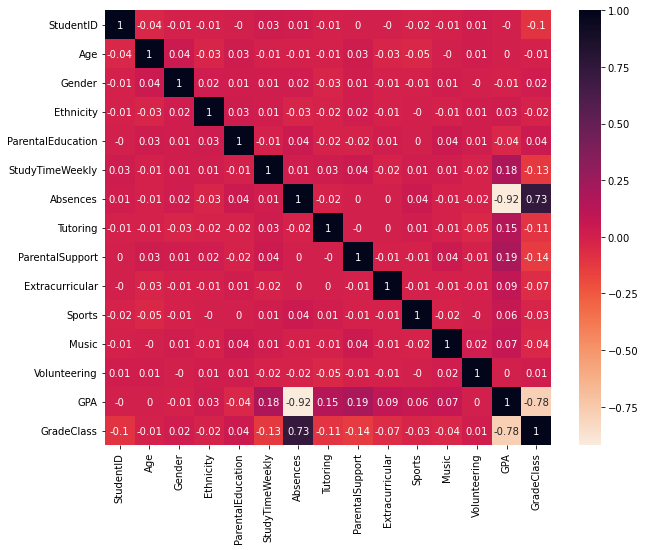

In [4]:
plt.figure(figsize = (10,8))
correlation_matrix = grade.corr().round(2)

sns.heatmap(data = correlation_matrix, annot = True, cmap = 'rocket_r')

In [5]:
data_path = "data"
grade = grade.drop(["StudentID"], axis=1)
grade.to_csv(os.path.join(data_path, "data.csv"), index=False)

In [6]:
grade.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2392 entries, 0 to 2391
Data columns (total 14 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   Age                2392 non-null   int64  
 1   Gender             2392 non-null   int64  
 2   Ethnicity          2392 non-null   int64  
 3   ParentalEducation  2392 non-null   int64  
 4   StudyTimeWeekly    2392 non-null   float64
 5   Absences           2392 non-null   int64  
 6   Tutoring           2392 non-null   int64  
 7   ParentalSupport    2392 non-null   int64  
 8   Extracurricular    2392 non-null   int64  
 9   Sports             2392 non-null   int64  
 10  Music              2392 non-null   int64  
 11  Volunteering       2392 non-null   int64  
 12  GPA                2392 non-null   float64
 13  GradeClass         2392 non-null   float64
dtypes: float64(3), int64(11)
memory usage: 261.8 KB


In [7]:
grade.head()

,Age,Gender,Ethnicity,ParentalEducation,StudyTimeWeekly,Absences,Tutoring,ParentalSupport,Extracurricular,Sports,Music,Volunteering,GPA,GradeClass
0,17,1,0,2,19.833723,7,1,2,0,0,1,0,2.929196,2.0
1,18,0,0,1,15.408756,0,0,1,0,0,0,0,3.042915,1.0
2,15,0,2,3,4.210570,26,0,2,0,0,0,0,0.112602,4.0
3,17,1,0,3,10.028829,14,0,3,1,0,0,0,2.054218,3.0
4,17,1,0,2,4.672495,17,1,3,0,0,0,0,1.288061,4.0


In [8]:
DATA_ROOT = 'data'

In [9]:
interactive_context = InteractiveContext(pipeline_root = PIPELINE_ROOT)

In [10]:
output = example_gen_pb2.Output(
    split_config = example_gen_pb2.SplitConfig(
        splits=[
            example_gen_pb2.SplitConfig.Split(name="train", hash_buckets=8),
            example_gen_pb2.SplitConfig.Split(name="eval", hash_buckets=2)
        ]
    )
)

example_gen = CsvExampleGen(input_base=DATA_ROOT, output_config=output)
interactive_context.run(example_gen)

ExecutionResult(
    component_id: CsvExampleGen
    execution_id: 1
    outputs:
        examples: OutputChannel(artifact_type=Examples, producer_component_id=CsvExampleGen, output_key=examples, additional_properties={}, additional_custom_properties={}))

In [11]:
statistic_gen = StatisticsGen(
    examples=example_gen.outputs["examples"]
)

interactive_context.run(statistic_gen)

ExecutionResult(
    component_id: StatisticsGen
    execution_id: 2
    outputs:
        statistics: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=StatisticsGen, output_key=statistics, additional_properties={}, additional_custom_properties={}))

In [12]:
interactive_context.show(statistic_gen.outputs['statistics'])

In [13]:
schema_gen = SchemaGen(statistics = statistic_gen.outputs["statistics"])

interactive_context.run(schema_gen)

ExecutionResult(
    component_id: SchemaGen
    execution_id: 3
    outputs:
        schema: OutputChannel(artifact_type=Schema, producer_component_id=SchemaGen, output_key=schema, additional_properties={}, additional_custom_properties={}))

In [14]:
interactive_context.show(schema_gen.outputs['schema'])

,Type,Presence,Valency,Domain
Feature name,,,,
'Absences',INT,required,,-
'Age',INT,required,,-
'Ethnicity',INT,required,,-
'Extracurricular',INT,required,,-
'GPA',FLOAT,required,,-
'Gender',INT,required,,-
'GradeClass',FLOAT,required,,-
'Music',INT,required,,-
'ParentalEducation',INT,required,,-


In [15]:
example_validator = ExampleValidator(
    statistics=statistic_gen.outputs['statistics'],
    schema=schema_gen.outputs['schema']
)

interactive_context.run(example_validator)

ExecutionResult(
    component_id: ExampleValidator
    execution_id: 4
    outputs:
        anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=ExampleValidator, output_key=anomalies, additional_properties={}, additional_custom_properties={}))

In [16]:
interactive_context.show(example_validator.outputs['anomalies'])

In [17]:
TRANSFORM_MODULE_FILE = "transform.py"

transform = Transform(
    examples=example_gen.outputs["examples"],
    schema=schema_gen.outputs["schema"],
    module_file=os.path.abspath(TRANSFORM_MODULE_FILE)
)

interactive_context.run(transform)

Instructions for updating:
Use ref() instead.


Instructions for updating:
Use ref() instead.


INFO:tensorflow:Assets written to: pipeline\grade-pipeline\Transform\transform_graph\5\.temp_path\tftransform_tmp\781db7ecc6a44b2591c8e00748dd4f7c\assets


INFO:tensorflow:Assets written to: pipeline\grade-pipeline\Transform\transform_graph\5\.temp_path\tftransform_tmp\781db7ecc6a44b2591c8e00748dd4f7c\assets


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:Assets written to: pipeline\grade-pipeline\Transform\transform_graph\5\.temp_path\tftransform_tmp\cc4b42bf4520443bb258f8e5d44f159b\assets


INFO:tensorflow:Assets written to: pipeline\grade-pipeline\Transform\transform_graph\5\.temp_path\tftransform_tmp\cc4b42bf4520443bb258f8e5d44f159b\assets


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


ExecutionResult(
    component_id: Transform
    execution_id: 5
    outputs:
        transform_graph: OutputChannel(artifact_type=TransformGraph, producer_component_id=Transform, output_key=transform_graph, additional_properties={}, additional_custom_properties={})
        transformed_examples: OutputChannel(artifact_type=Examples, producer_component_id=Transform, output_key=transformed_examples, additional_properties={}, additional_custom_properties={})
        updated_analyzer_cache: OutputChannel(artifact_type=TransformCache, producer_component_id=Transform, output_key=updated_analyzer_cache, additional_properties={}, additional_custom_properties={})
        pre_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=pre_transform_schema, additional_properties={}, additional_custom_properties={})
        pre_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=pre_transform_stats, additional_properties={}, additional_custom_properties={})
        post_transform_schema: OutputChannel(artifact_type=Schema, producer_component_id=Transform, output_key=post_transform_schema, additional_properties={}, additional_custom_properties={})
        post_transform_stats: OutputChannel(artifact_type=ExampleStatistics, producer_component_id=Transform, output_key=post_transform_stats, additional_properties={}, additional_custom_properties={})
        post_transform_anomalies: OutputChannel(artifact_type=ExampleAnomalies, producer_component_id=Transform, output_key=post_transform_anomalies, additional_properties={}, additional_custom_properties={}))

In [18]:
TUNER_MODULE_FILE = "tuner.py"

tuner = Tuner(
    module_file=os.path.abspath(TUNER_MODULE_FILE),
    examples=transform.outputs['transformed_examples'],
    transform_graph=transform.outputs['transform_graph'],
    schema=schema_gen.outputs['schema'],
    train_args=trainer_pb2.TrainArgs(splits=['train'], num_steps=10),
    eval_args=trainer_pb2.EvalArgs(splits=['eval'], num_steps=20),
)

interactive_context.run(tuner)

Trial 20 Complete [00h 00m 14s]
val_accuracy: 0.6600000262260437

Best val_accuracy So Far: 0.699999988079071
Total elapsed time: 00h 05m 38s
INFO:tensorflow:Oracle triggered exit


INFO:tensorflow:Oracle triggered exit


Results summary
Results in pipeline\grade-pipeline\.temp\6\kt_hyperband
Showing 10 best trials
Objective(name="val_accuracy", direction="max")

Trial 06 summary
Hyperparameters:
unit_1: 256
dropout_1: 0.2
unit_2: 128
dropout_2: 0.2
unit_3: 128
dropout_3: 0.2
learning_rate: 0.0005
Score: 0.699999988079071

Trial 09 summary
Hyperparameters:
unit_1: 128
dropout_1: 0.2
unit_2: 256
dropout_2: 0.3
unit_3: 64
dropout_3: 0.3
learning_rate: 0.001
Score: 0.6850000023841858

Trial 01 summary
Hyperparameters:
unit_1: 128
dropout_1: 0.2
unit_2: 64
dropout_2: 0.3
unit_3: 64
dropout_3: 0.3
learning_rate: 0.001
Score: 0.675000011920929

Trial 04 summary
Hyperparameters:
unit_1: 128
dropout_1: 0.3
unit_2: 256
dropout_2: 0.3
unit_3: 128
dropout_3: 0.2
learning_rate: 0.001
Score: 0.6700000166893005

Trial 19 summary
Hyperparameters:
unit_1: 256
dropout_1: 0.2
unit_2: 64
dropout_2: 0.4
unit_3: 32
dropout_3: 0.4
learning_rate: 0.001
Score: 0.6600000262260437

Trial 10 summary
Hyperparameters:
unit_1: 256
d

ExecutionResult(
    component_id: Tuner
    execution_id: 6
    outputs:
        best_hyperparameters: OutputChannel(artifact_type=HyperParameters, producer_component_id=Tuner, output_key=best_hyperparameters, additional_properties={}, additional_custom_properties={})
        tuner_results: OutputChannel(artifact_type=TunerResults, producer_component_id=Tuner, output_key=tuner_results, additional_properties={}, additional_custom_properties={}))

In [19]:
TRAINER_MODULE_FILE = "trainer.py"

trainer = Trainer(
    module_file=os.path.abspath(TRAINER_MODULE_FILE),
    examples=transform.outputs['transformed_examples'],
    transform_graph=transform.outputs['transform_graph'],
    schema=schema_gen.outputs['schema'],
    hyperparameters=tuner.outputs['best_hyperparameters'],
    train_args=trainer_pb2.TrainArgs(splits=['train'], num_steps=1000),
    eval_args=trainer_pb2.EvalArgs(splits=['eval'], num_steps=200), 
)

interactive_context.run(trainer)

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Age_xf (InputLayer)            [(None, 1)]          0           []                               
                                                                                                  
 Gender_xf (InputLayer)         [(None, 1)]          0           []                               
                                                                                                  
 Ethnicity_xf (InputLayer)      [(None, 1)]          0           []                               
                                                                                                  
 ParentalEducation_xf (InputLay  [(None, 1)]         0           []                               
 er)                                                                                        

INFO:tensorflow:struct2tensor is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_decision_forests is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:tensorflow_text is not available.


INFO:tensorflow:Assets written to: pipeline\grade-pipeline\Trainer\model\7\Format-Serving\assets


INFO:tensorflow:Assets written to: pipeline\grade-pipeline\Trainer\model\7\Format-Serving\assets


ExecutionResult(
    component_id: Trainer
    execution_id: 7
    outputs:
        model: OutputChannel(artifact_type=Model, producer_component_id=Trainer, output_key=model, additional_properties={}, additional_custom_properties={})
        model_run: OutputChannel(artifact_type=ModelRun, producer_component_id=Trainer, output_key=model_run, additional_properties={}, additional_custom_properties={}))

In [20]:
model_resolver = Resolver(
    strategy_class = LatestBlessedModelStrategy,
    model = Channel(type = Model),
    model_blessing = Channel(type = ModelBlessing)
).with_id('Latest_blessed_model_resolver')

interactive_context.run(model_resolver)

ExecutionResult(
    component_id: Latest_blessed_model_resolver
    execution_id: 8
    outputs:
        model: OutputChannel(artifact_type=Model, producer_component_id=Latest_blessed_model_resolver, output_key=model, additional_properties={}, additional_custom_properties={})
        model_blessing: OutputChannel(artifact_type=ModelBlessing, producer_component_id=Latest_blessed_model_resolver, output_key=model_blessing, additional_properties={}, additional_custom_properties={}))

In [21]:
eval_config = tfma.EvalConfig(
    model_specs = [tfma.ModelSpec(label_key = 'GradeClass')],
    slicing_specs = [tfma.SlicingSpec()],
    metrics_specs = [
        tfma.MetricsSpec(metrics = [
                tfma.MetricConfig(class_name = 'ExampleCount'),
                tfma.MetricConfig(class_name = 'AUC'),
                tfma.MetricConfig(class_name = 'FalsePositives'),
                tfma.MetricConfig(class_name = 'TruePositives'),
                tfma.MetricConfig(class_name = 'FalseNegatives'),
                tfma.MetricConfig(class_name = 'TrueNegatives'),
                tfma.MetricConfig(class_name = 'CategoricalAccuracy',
                    threshold = tfma.MetricThreshold(
                        value_threshold = tfma.GenericValueThreshold(
                            lower_bound = {'value' : 0.5}
                    ),
                    change_threshold = tfma.GenericChangeThreshold(
                        direction = tfma.MetricDirection.HIGHER_IS_BETTER,
                            absolute = {'value' : 0.0001}
                    )
                )
            )
        ])
    ]
)

In [22]:
evaluator = Evaluator(
    examples = example_gen.outputs['examples'],
    model = trainer.outputs['model'],
    baseline_model = model_resolver.outputs['model'],
    eval_config = eval_config
)

interactive_context.run(evaluator)

Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


Instructions for updating:
Use eager execution and: 
`tf.data.TFRecordDataset(path)`


ExecutionResult(
    component_id: Evaluator
    execution_id: 9
    outputs:
        evaluation: OutputChannel(artifact_type=ModelEvaluation, producer_component_id=Evaluator, output_key=evaluation, additional_properties={}, additional_custom_properties={})
        blessing: OutputChannel(artifact_type=ModelBlessing, producer_component_id=Evaluator, output_key=blessing, additional_properties={}, additional_custom_properties={}))

In [23]:
eval_result = evaluator.outputs['evaluation'].get()[0].uri
tfma_result = tfma.load_eval_result(eval_result)
tfma.view.render_slicing_metrics(tfma_result)
tfma.addons.fairness.view.widget_view.render_fairness_indicator(
    tfma_result
)

FairnessIndicatorViewer(slicingMetrics=[{'sliceValue': 'Overall', 'slice': 'Overall', 'metrics': {'accuracy': …

In [24]:
pusher = Pusher(
    model = trainer.outputs['model'],
    model_blessing = evaluator.outputs['blessing'],
    push_destination = pusher_pb2.PushDestination(
        filesystem = pusher_pb2.PushDestination.Filesystem(
            base_directory = "serving_model_dir/stress-prediction-model"
        )
    )
)

interactive_context.run(pusher)

ExecutionResult(
    component_id: Pusher
    execution_id: 10
    outputs:
        pushed_model: OutputChannel(artifact_type=PushedModel, producer_component_id=Pusher, output_key=pushed_model, additional_properties={}, additional_custom_properties={}))